Get Externals, Note use of commentjson

In [1]:
import os,sys,string,time,commentjson,datetime
from csv import reader
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import numpy as np

In [2]:
# sum backwards over lifetime of record
def cumulate(a,lifetime=100):
  if lifetime < 1:
    return a*lifetime
  b = np.zeros(len(a))
  for i in range(0,len(a)):
    begin = max(0,i-lifetime+1)
    for j in range(begin,i+1):
      b[i] += a[j]
  return b
  

Utility function: string = dump(datatype,det,object,Units)

In [3]:
from NumberUtils import dump
from NumberUtils import DrawTex


Utility function: DrawDet(Value,Years,Data,Types,Units,detcolors,detlines)

In [4]:
from NumberUtils import DrawDet  


Utility function: DrawType(Value,Years,Data,Types,Units,typecolors,typelines)

In [5]:
# draw by data type (transpose of the detectors)
from NumberUtils import DrawType

Main initialization

Read in the config file "Parameters2040.json"

In [6]:
# get parameters into config

configfile = "Parameters_2021-07-25-2030.json"

if os.path.exists(configfile):
  with open(configfile,'r') as f:
    config = commentjson.load(f)
else:
  print ("no config file",configfile)
  sys.exit(0)

Print the json file 

In [7]:
json_formatted_str = commentjson.dumps(config, indent=2)

#print(json_formatted_str)

    Set up parameters from input file 

In [8]:
# set up shortcuts for parameters

MaxYears = config["MaxYears"]
MinYears = config["MinYears"]
Years = np.array(config["Years"][0:MaxYears])
print (Years, len(Years))
size = len(Years)

Units = config["Units"]

Detectors = config["Detectors"]

CombinedDetectors = config["CombinedDetectors"]

DetectorParameters = list(config["SP"].keys())
if "Comment" in DetectorParameters:
    DetectorParameters.remove("Comment")

TapeLifetimes = config["TapeLifetimes"]

DiskLifetimes = config["DiskLifetimes"]

TapeCopies = config["TapeCopies"]

DiskCopies = config["DiskCopies"]

RecoMemory = config["RecoMemory"]

SplitsEarly = config["SplitsEarly"]
SplitsLater = config["SplitsLater"]

# this is to deal with CERN not doing storage for main DUNE

Splits = {}
for f in SplitsEarly:
    Splits[f] = {}
    for t in SplitsEarly[f]:
        Splits[f][t] = {}
        for loc in SplitsEarly[f][t]: 
           # Splits[f][t][loc] = {}
            print (f,loc,t,SplitsEarly[f][t][loc])
            Splits[f][t][loc] = np.zeros(len(Years))
            #print (f,t,Splits[f][t],Splits[f][t][0])
    
            for y in range(0,len(Years)):
                if y < 9:
                    #print ("test",f, t, y, Splits[f][t][y],SplitsEarly[f][t])
                    Splits[f][t][loc][y]=SplitsEarly[f][t][loc]
                else:
                    Splits[f][t][loc][y]=SplitsLater[f][t][loc]

#print (Splits)

[2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030] 13
Tape FNAL Raw 0.5
Tape CERN Raw 0.5
Tape Collab Raw 0.0
Tape FNAL Sim 0.75
Tape CERN Sim 0.0
Tape Collab Sim 0.25
Tape FNAL Reco 0.75
Tape CERN Reco 0.0
Tape Collab Reco 0.25
Tape FNAL Test 0.5
Tape CERN Test 0.5
Tape Collab Test 0.0
Disk FNAL Raw 0.5
Disk CERN Raw 0.5
Disk Collab Raw 0.0
Disk FNAL Sim 0.25
Disk CERN Sim 0.0
Disk Collab Sim 0.75
Disk FNAL Reco 0.25
Disk CERN Reco 0.0
Disk Collab Reco 0.75
Disk FNAL Test 0.5
Disk CERN Test 0.5
Disk Collab Test 0.0


In [9]:
PerYear = config["PerYear"]
print (TapeLifetimes)
table = open(configfile.replace("json","txt"),'w')

tex = open(configfile.replace("json","tex"),'w')
s = "\\documentclass[12pt]{article}\n\\usepackage{graphicx}\n"
s += "\\usepackage{hyperref}\n"
s += "\\parindent=0pt\n\\setlength{\\textwidth=7in}\n"
s += "\\setlength{\\oddsidemargin=-.25 in}\n"
s += "\\setlength{\\topmargin=0 in}\n"
s += "\\setlength{\\textheight=9.5 in}\n\\begin{document}\n"
print(s)
tex.write(s)
s = "\\centerline{\\bf{DUNE Resource Needs for 2022}}\\vskip 1 in \\par Configuration: %s\nDate: %sTZ\n \n"%(configfile,(datetime.datetime.utcnow().strftime("%Y-%m-%d %H:%M")))
print(s)

table.write(s)
tex.write(s.replace("_","\_").replace("\n","\\\\\n  "))
#tex.write("\hline\n")
tex.write("\\input intro.tex\n ")
s = "Fiscal year starts: %s\nTape is accounted for at: %s\nDisk is accounted for on: %s\nCPU is accounted for at: %s\n"%\
(config["FiscalYearStart"],config["Tape Accounting"],config["Disk Accounting"],config["CPU Accounting"])
table.write(s)
print(s)
tex.write(s.replace("\n","\\\\ \n"))

s = "Reco passes per Year: %s\nSim passes per Year: %s\nAnalysis relative to Sim+Reco: %s\n"%(PerYear["CPU"],PerYear["Sim-CPU"],config["Analysis"]["Scale"])
table.write(s)
print(s)
tex.write(s.replace("\n","\\\\\n"))

tex.write("\\pagebreak\n")
s = ""
for type in TapeLifetimes:
    s += "\n{\\bf For data type %s}\n"%type
   # print (s)
   # table.write(s)
    s += "%6s Tape lifetime %5.1f in years\n"%(type,TapeLifetimes[type])
   # print (s)
   # table.write(s)
    s += "%6s Tape Copies %5.1f\n"%(type,TapeCopies[type])
   # print (s)
  #  table.write(s)
    s += "%6s FNAL Tape fraction for PD %5.2f\n"%(type,SplitsEarly["Tape"][type]["FNAL"])
    s += "%6s FNAL Tape fraction for DUNE %5.2f\n"%(type,SplitsLater["Tape"][type]["FNAL"])
    s += "%6s CERN Tape fraction for PD %5.2f\n"%(type,SplitsEarly["Tape"][type]["CERN"])
    s += "%6s CERN Tape fraction for DUNE %5.2f\n"%(type,SplitsLater["Tape"][type]["CERN"])
    s += "%6s Collaboration Tape fraction for PD %5.2f\n"%(type,SplitsEarly["Tape"][type]["Collab"])
    s += "%6s Collaboration Tape fraction for DUNE %5.2f\n"%(type,SplitsLater["Tape"][type]["Collab"])
   # print (s)
  #  table.write(s)
    s += "%6s Disk lifetime %5.1f in years\n"%(type,DiskLifetimes[type])
   # print (s)
  #  table.write(s)
    s += "%6s Disk Copies %5.1f\n"%(type,DiskCopies[type])
   # print (s)
  #  table.write(s)
    s += "%6s FNAL Disk fraction for PD %5.2f\n"%(type,SplitsEarly["Disk"][type]["FNAL"])
    s += "%6s FNAL Disk fraction for DUNE %5.2f\n"%(type,SplitsLater["Disk"][type]["FNAL"])
    s += "%6s CERN Disk fraction for PD %5.2f\n"%(type,SplitsEarly["Disk"][type]["CERN"])
    s += "%6s CERNDisk fraction for DUNE %5.2f\n"%(type,SplitsLater["Disk"][type]["CERN"])
    s += "%6s Collaboration Disk fraction for PD %5.2f\n"%(type,SplitsEarly["Disk"][type]["Collab"])
    s += "%6s Collaboration Disk fraction for DUNE %5.2f\n"%(type,SplitsLater["Disk"][type]["Collab"])
    s+="\\pagebreak\n"
  #  print (s)
  #  table.write(s)
    
print(s)
table.write(s)
tex.write(s.replace("\n","\\\\\n"))

#table.write("Calendar Years")
    
StorageTypes = list(TapeCopies.keys())

# plot config
DetColors=config["DetColors"]
DetLines = config["DetLines"]
TypeColors=config["TypeColors"]
TypeLines = config["TypeLines"]

{'Raw': 100, 'Test': 0.5, 'Reco': 15, 'Sim': 15}
\documentclass[12pt]{article}
\usepackage{graphicx}
\usepackage{hyperref}
\parindent=0pt
\setlength{\textwidth=7in}
\setlength{\oddsidemargin=-.25 in}
\setlength{\topmargin=0 in}
\setlength{\textheight=9.5 in}
\begin{document}

\centerline{\bf{DUNE Resource Needs for 2022}}\vskip 1 in \par Configuration: Parameters_2021-07-25-2030.json
Date: 2021-09-12 16:59TZ
 

Fiscal year starts: April 1
Tape is accounted for at: end of fiscal year
Disk is accounted for on: October 1
CPU is accounted for at: end of fiscal year

Reco passes per Year: 1
Sim passes per Year: 1
Analysis relative to Sim+Reco: 1


{\bf For data type Raw}
   Raw Tape lifetime 100.0 in years
   Raw Tape Copies   2.0
   Raw FNAL Tape fraction for PD  0.50
   Raw FNAL Tape fraction for DUNE  0.50
   Raw CERN Tape fraction for PD  0.50
   Raw CERN Tape fraction for DUNE  0.00
   Raw Collaboration Tape fraction for PD  0.00
   Raw Collaboration Tape fraction for DUNE  0.50
   Raw

Make data structures - Inputs and Data 

Data[type][det] is an dictionary keyed on type and detector

In [10]:
# build the inputs array

Inputs = {}
PatternFraction = config["PatternFraction"]
# get in the input values (Events and amount of commissioning in TB)
 
# these variables are set in the json 

dofirst = ["Events","Test","Sim Events"]

for det in ["SP","DP","ND","FD"]:
  Inputs[det]={}
  for type in dofirst:
    Inputs[det][type] = np.array(config[det][type])
    Inputs[det][type].resize(MaxYears)
     
    #print ("size", det,type, Inputs[det][type].size)
    

In [11]:
# use those to calculate CPU and space needs
    
for det in Detectors:
    
  for key in DetectorParameters:
    # skip the ones already done
    if key in dofirst:
      continue
    # sim has its own configuration 
    if not "Sim" in key:
      
      if key in ["CPU","Reco"]:  # if doing reco, do over previous events using memory
            Inputs[det][key] = cumulate(Inputs[det]["Events"],RecoMemory[det])*config[det][key]
             
      else:
            Inputs[det][key]=Inputs[det]["Events"]*config[det][key]
    else:
      Inputs[det][key]=Inputs[det]["Sim Events"]*config[det][key]
    print (det,key)
      
# write some of this out
#print (Inputs["ND"])
o = open("out.csv",'w')
o.write(dump("Year","Years",Years,Units))


SP Raw
SP CPU
SP Sim-CPU
SP Reco
SP Sim
DP Raw
DP CPU
DP Sim-CPU
DP Reco
DP Sim
FD Raw
FD CPU
FD Sim-CPU
FD Reco
FD Sim
ND Raw
ND CPU
ND Sim-CPU
ND Reco
ND Sim


151

In [12]:
# use inputs to calculate per year sizes and store in transposed map Data
if PerYear["Reco"]!=PerYear["CPU"]:
    print ("Data growth has to match reprocessing cycles/year")
    PerYear["Reco"] = PerYear["CPU"]
if PerYear["Sim"]!=PerYear["Sim-CPU"]:
    print ("Sim growth has to match reprocessing cycles/year")
    PerYear["Sim"] = PerYear["Sim-CPU"]
    
Data = {}
#print (Inputs.keys())
for dtype in Inputs["ND"].keys():
  Data[dtype] = {} 
  #Data["Full-Reco"] = {}
  for det in Inputs.keys():
    # this allows you to, say, do 2 passes of reco/year
    Data[dtype][det] = Inputs[det][dtype] * float(PerYear[dtype])  
    # compensate for nominal units being millions and TB or singles and MB
    if Units[dtype] == "PB":
      Data[dtype][det] *= 0.001
    o.write(dump(det,dtype,Data[dtype][det],Units))
    
# replace Reco with reconstruction over previous years



For FD and ND assume reprocess full sample when get new reco version 

In [13]:
#print ("types",Data.keys())
#print ("detectors", Data["Events"].keys())
print ("values", Data["Events"]["FD"])#

values [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.2 2.2 4.4]


Now draw the # of events/year

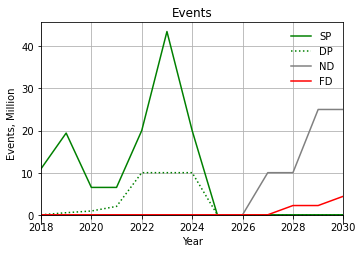

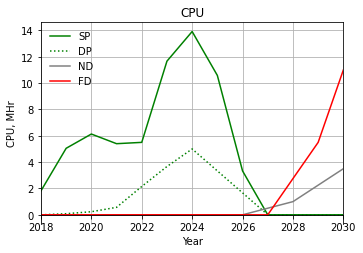

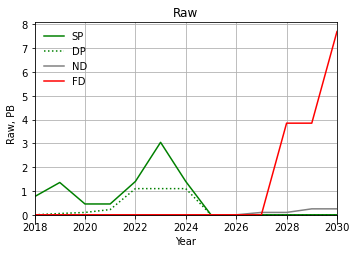

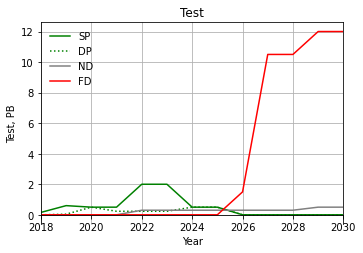

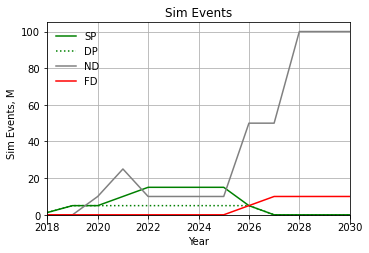

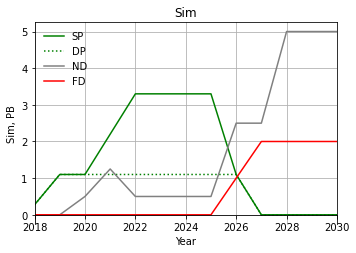

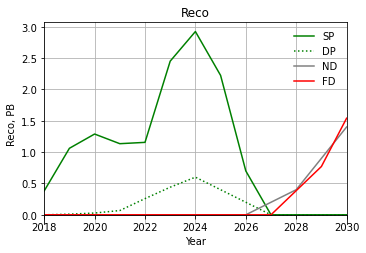

In [14]:
DrawDet("Events",Years,Data,Inputs.keys(),Units,DetColors,DetLines)
#DrawDet("CPU",Years,Data,Inputs.keys(),Units,DetColors,DetLines)
DrawDet("CPU",Years,Data,Inputs.keys(),Units,DetColors,DetLines)
DrawDet("Raw",Years,Data,Inputs.keys(),Units,DetColors,DetLines)
DrawDet("Test",Years,Data,Inputs.keys(),Units,DetColors,DetLines)
DrawDet("Sim Events",Years,Data,Inputs.keys(),Units,DetColors,DetLines)
DrawDet("Sim",Years,Data,Inputs.keys(),Units,DetColors,DetLines)
DrawDet("Reco",Years,Data,Inputs.keys(),Units,DetColors,DetLines)



Combine the protoDUNEs into one and replace them in Data

In [15]:
# combine ProtoDUNEs into one and get rid of SP and DP
 
 
for dtype in Data.keys():
  det = "ProtoDUNE"
  #print (dtype)
  Data[dtype][det] = Data[dtype]["SP"] + Data[dtype]["DP"]
  Data[dtype].pop("SP")
  Data[dtype].pop("DP")

  o.write(dump(det,dtype,Data[dtype][det],Units))

Make a Total-CPU datatype, and a Total "detector" which sums over detectors

In [16]:
# make a total CPU category

Data["Total-CPU"]={}

for det in CombinedDetectors:
  Data["Total-CPU"][det] =  Data["CPU"][det] + Data["Sim-CPU"][det]
  
  
Data.pop("CPU")
# sum up data across detectors.

DataTypes = list(Data.keys())
print (DataTypes)

for dt in DataTypes:
  Data[dt]["Total"] = np.zeros(size)
  for k in Data[dt].keys():
    if k == "Total":
      continue
    Data[dt]["Total"] += Data[dt][k]

['Events', 'Test', 'Sim Events', 'Raw', 'Sim-CPU', 'Reco', 'Sim', 'Total-CPU']


Make an Analysis "detector" that scales with sum of CPU use for all detectors them and add into Total-CPU

In [17]:
# assume analysis CPU = some multiplier of total sim + reco

Data["Total-CPU"]["Analysis"]= np.zeros(size)
for det in config["Analysis"]["Add"]:
    # scale allows you to change the scale of analysis relative to reconstruction and simulations
  Data["Total-CPU"]["Analysis"]+= Data["Total-CPU"][det]*config["Analysis"]["Scale"]
  
o.write(dump("Analysis","Total-CPU",Data["Total-CPU"]["Analysis"],Units))
  
# and put it in the total

Data["Total-CPU"]["Total"] += Data["Total-CPU"]["Analysis"]

Make a Cores type that is just CPU scaled to a 2020 CPU with some efficiency

In [18]:
# and make a special data type for cores

Data["Cores"] = {}
Data["SPEC06"] = {}
MHrsPerYear = 1000000./365/24
for k in Data["Total-CPU"].keys():
  efficiency = config["Cores"]["Efficiency"]
  scaleTo2020 = config["Cores"]["2020Units"]
  Data["Cores"][k] = Data["Total-CPU"][k]*MHrsPerYear/efficiency/scaleTo2020
  Data["SPEC06"][k] = Data["Total-CPU"][k]*MHrsPerYear/efficiency/scaleTo2020*config["kHEPSPEC06PerCPU"]

In [19]:

# write out the totals

for k in Data.keys():
  #print ("total:",k,Units[k], Data[k]["Total"])
  o.write(dump("Total",k,Data[k]["Total"],Units))


Use the data lifetimes and # of copies to sum up cumulative amounts for disk and tape 

In [20]:

# now do some cumulative work.  Stuff stays on tape/disk for different amounts of time and we have multiple copies

Data["Total"] = {}
Data["Collab"] = {}
Data["FNAL"] = {}
Data["CERN"] = {}
Data["Total"]["Cumulative Tape"] = 0
Data["Total"]["Cumulative Disk"] = 0
Data["FNAL"]["Cumulative Tape"] = 0
Data["FNAL"]["Cumulative Disk"] = 0
Data["CERN"]["Cumulative Tape"] = 0
Data["CERN"]["Cumulative Disk"] = 0
Data["Collab"]["Cumulative Tape"] = 0
Data["Collab"]["Cumulative Disk"] = 0
print (StorageTypes)


for k in StorageTypes:
  Data[k]["Tape"] = Data[k]["Total"]*TapeCopies[k]
  o.write(dump("Tape Copies",k,Data[k]["Tape"],Units))
  Data[k]["Disk"] = Data[k]["Total"]*DiskCopies[k]
  o.write(dump("Disk Copies",k,Data[k]["Disk"],Units))
  Data[k]["Cumulative Tape"] = cumulate(Data[k]["Tape"],TapeLifetimes[k])
  #o.write(dump("Cumulative Tape",k,Data[k]["Cumulative Tape"],Units))
  Data[k]["Cumulative Disk"] = cumulate(Data[k]["Disk"],DiskLifetimes[k])
  print (k, "disk",Data[k]["Disk"],DiskLifetimes[k],cumulate(Data[k]["Disk"],DiskLifetimes[k]))
  o.write(dump("Cumulative Disk",k,Data[k]["Cumulative Disk"],Units ))
  o.write(dump("Cumulative Tape",k,Data[k]["Cumulative Tape"],Units ))
  Data["Total"]["Cumulative Tape"] += Data[k]["Cumulative Tape"]
  Data["Total"]["Cumulative Disk"] += Data[k]["Cumulative Disk"]
  for loc in Splits["Disk"]["Raw"]:
      Data[loc]["Cumulative Disk"] += Data[k]["Cumulative Disk"]*Splits["Disk"][k][loc]
      Data[loc]["Cumulative Tape"] += Data[k]["Cumulative Tape"]*Splits["Tape"][k][loc]
      print (k,loc,Data[loc]["Cumulative Disk"])
      print (k,loc,Data[loc]["Cumulative Tape"])
o.write(dump("Cumulative Tape","All",Data["Total"]["Cumulative Tape"],Units ))
o.write(dump("Cumulative Disk","All",Data["Total"]["Cumulative Disk"],Units ))



['Raw', 'Test', 'Reco', 'Sim']
Raw disk [0.763 1.413 0.554 0.675 2.5   4.145 2.5   0.    0.    0.1   3.95  4.1
 7.95 ] 1 [0.763 1.413 0.554 0.675 2.5   4.145 2.5   0.    0.    0.1   3.95  4.1
 7.95 ]
Raw FNAL [0.3815 0.7065 0.277  0.3375 1.25   2.0725 1.25   0.     0.     0.1
 3.95   4.1    7.95  ]
Raw FNAL [ 0.763  2.176  2.73   3.405  5.905 10.05  12.55  12.55  12.55  12.65
 16.6   20.7   28.65 ]
Raw CERN [0.3815 0.7065 0.277  0.3375 1.25   2.0725 1.25   0.     0.     0.
 0.     0.     0.    ]
Raw CERN [ 0.763  2.176  2.73   3.405  5.905 10.05  12.55  12.55  12.55   0.
  0.     0.     0.   ]
Raw Collab [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Raw Collab [ 0.    0.    0.    0.    0.    0.    0.    0.    0.   12.65 16.6  20.7
 28.65]
Test disk [0.0785 0.321  0.5    0.3655 1.2655 1.2655 0.65   0.65   0.9    5.4
 5.4    6.25   6.25  ] 0.5 [0.03925 0.1605  0.25    0.18275 0.63275 0.63275 0.325   0.325   0.45
 2.7     2.7     3.125   3.125  ]
Test FNAL [0.401125 0.78675  0.402    0.428875 

163

Draw various summaries

In [21]:
Types = ["ProtoDUNE","FD","ND","Analysis","Total"]

# print (dump("Year","Years",Years,Units))
# print (dump("Total","Cumulative Tape",Data["Total"]["Cumulative Tape"],Units))
# print (dump("Total","Cumulative Disk",Data["Total"]["Cumulative Disk"],Units))


tex.write("\\begin{table}\n\\footnotesize\n \\centering \\begin{tabular}[h]{crrrrrcccc}\n")
             
s =  " ,\t CPU ,\tWall,\tWall F/C,\t\qquad  ,\t Tape\qquad,\t Tape\qquad  ,\t Disk\qquad  ,\t Disk\qquad \n"
s +=  "Years,\t(Mhrs),\tkSPEC06,\tkSPEC06,\tcores,\t Total(PB),\tF/C/Collab ,\t Total(PB) ,\tF/C/Collab\n"

table.write(s)
print(s)
tex.write(s.replace("\n","\\\\\n").replace(",\t","&"))
#s = "Assume present core is %6.3f kSPEC06 \nCPU # is real CPU, Cores and SPEC06 are Walltime with CPU/Walltime = %5.2f\n"%(config["kHEPSPEC06PerCPU"], config["Cores"]["Efficiency"])
#print (s)
#table.write(s)
tex.write("\hline\n")

cores = Data["Cores"]["Total"]
cpu = Data["Total-CPU"]["Total"]
disk = Data["Total"]["Cumulative Disk"]
tape = Data["Total"]["Cumulative Tape"]
diskF = Data["FNAL"]["Cumulative Disk"]
tapeF = Data["FNAL"]["Cumulative Tape"]
diskCE = Data["CERN"]["Cumulative Disk"]
tapeCE= Data["CERN"]["Cumulative Tape"]
diskC = Data["Collab"]["Cumulative Disk"]
tapeC = Data["Collab"]["Cumulative Tape"]
hep = Data["SPEC06"]["Total"]
#print (cpu,cores,disk,tape)

# CPUused = np.zeros(len(Years))

  
# for t in config["USED"]["CPU"]:
        
#         for site in config["USED"]["CPU"][t]:
#             print (t,site)
#             for y in range(0,len(Years)):
#                 print (t,site,y,config["USED"]["CPU"][t][site][y])
#                 CPUused[y]+=config["USED"]["CPU"][t][site][y]
        

 ,	 CPU ,	Wall,	Wall F/C,	\qquad  ,	 Tape\qquad,	 Tape\qquad  ,	 Disk\qquad  ,	 Disk\qquad 
Years,	(Mhrs),	kSPEC06,	kSPEC06,	cores,	 Total(PB),	F/C/Collab ,	 Total(PB) ,	F/C/Collab



2021,	  40,	  73,	  18/  54,	  6594,	     21.1,	  14.1/  3.6/  3.5,	     20.4,	   5.3/  0.4/ 14.7
2022,	  48,	  86,	  21/  64,	  7779,	     33.4,	  21.8/  6.5/  5.1,	     27.3,	   7.6/  1.6/ 18.1
2023,	  63,	 113,	  28/  85,	 10286,	     49.4,	  31.7/ 10.7/  7.0,	     33.0,	   9.4/  2.4/ 21.2
2024,	  70,	 126,	  32/  95,	 11455,	     62.2,	  40.2/ 12.9/  9.1,	     35.2,	   9.5/  1.4/ 24.3
2025,	  60,	 108,	  27/  81,	  9824,	     69.8,	  45.9/ 12.9/ 11.0,	     32.2,	   8.1/  0.2/ 23.9
2026,	  45,	  80,	  20/  60,	  7257,	     76.6,	  51.0/ 13.0/ 12.7,	     28.7,	   7.3/  0.2/ 21.2
2027,	  28,	  50,	  13/  38,	  4566,	     86.0,	  43.0/  0.0/ 43.0,	     25.4,	   7.1/  0.0/ 18.3
2028,	  46,	  83,	  21/  63,	  7583,	    101.7,	  50.9/  0.0/ 50.9,	     31.6,	  11.5/  0.0/ 20.1
2029,	  54,	  98,	  24/  73,	  8888,	    119.4,	  59.7/  0.0/ 59.7,	     40.1,	  13.9/  0.0/ 26.2
2030,	  68,	 122,	  30/  91,	 11089,	    145.3,	  72.6/  0.0/ 72.6,	     48.3,	  18.8/  0.0/ 29.5

2021,	  40,	  73,	 

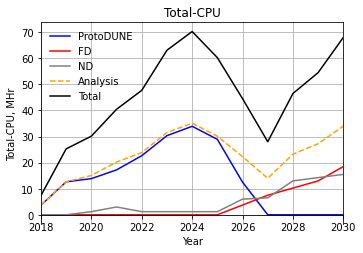

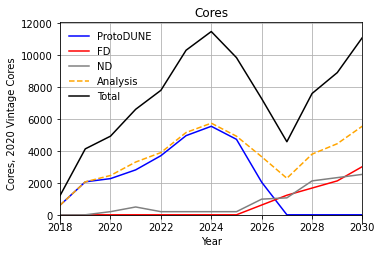

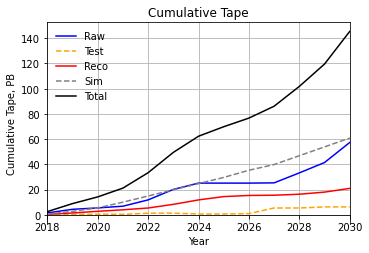

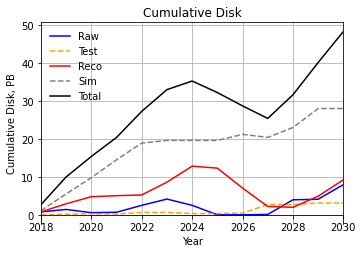

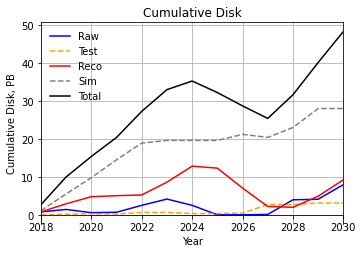

In [22]:
s = ""
for i in range(MinYears,len(Years)):  
    format = "%d,\t%4.0f,\t%4.0f,\t%4.0f/%4.0f,\t %5.0f,\t %8.1f,\t %5.1f/%5.1f/%5.1f,\t %8.1f,\t %5.1f/%5.1f/%5.1f\n"
    s += (format)%(Years[i],round(cpu[i]), round(hep[i]),round(hep[i]*.25),round(hep[i]*.75),round(cores[i]),tape[i],tapeF[i],tapeCE[i],tapeC[i],disk[i],diskF[i],diskCE[i],diskC[i])
print (s)
table.write(s)
caption = "Assume present core is %4.0f SPEC06. CPU number is real CPU. Cores and SPEC06 are Walltime with CPU/Walltime = %5.2f. "%(config["kHEPSPEC06PerCPU"]*1000, config["Cores"]["Efficiency"])
caption += " F means FNAL, C means CERN. Assume CERN storage is only  for ProtoDUNE."
caption += " CPU should be divided 25\% FNAL, 75\% Collab"
tex.write(s.replace("\n","\\\\\n").replace(",","&"))
tex.write("\\end{tabular}\n\\caption{%s}"%caption)
tex.write("\\normalsize\n \\end{table}\n")    

asssume = "Assume present core is %6.3f kSPEC06 \nCPU # is real CPU, Cores and SPEC06 are Walltime with CPU/Walltime = %5.2f\n"%(config["kHEPSPEC06PerCPU"], config["Cores"]["Efficiency"])

print (s)
table.write(s)
    
s = "https://github.com/DUNE/Computing-CDR/blob/master/Jupyter/Numbers/"    
print(s)
table.write(s)


DrawDet("Total-CPU",Years,Data,Types,Units,DetColors,DetLines)
DrawDet("Cores",Years,Data,Types,Units,DetColors,DetLines)

DrawType("Cumulative Tape",Years,Data,StorageTypes+["Total"],Units,TypeColors,TypeLines)
DrawType("Cumulative Disk",Years,Data,StorageTypes+["Total"],Units,TypeColors,TypeLines)
#DrawType("Disk",Years,Data,StorageTypes,Units,TypeColors,TypeLines)
# draw twice to fool print
DrawType("Cumulative Disk",Years,Data,StorageTypes+["Total"],Units,TypeColors,TypeLines)

In [23]:
table.close()
tex.write("\\pagebreak")
tex.write(DrawTex("Total-CPU.png","CPU time in Wall Hours/year","TotalCPU"))
tex.write(DrawTex("Cores.png","Cores needed, including efficiency loss","Cores"))
tex.write(DrawTex("Cumulative-Tape.png","Tape tape needs, PB, all types are cumulative over tape lifetime","CumulativeTape"))
tex.write(DrawTex("Cumulative-Disk","Disk needs, PB.  Reco and Sim are cumulative over disk lifetime.  Raw and Test have sub-year lifetimes.","CumulativeDisk"))
tex.write("\\vskip 3 in\\pagebreak \n {\\bf Change log:}\\\\\n")
for c in config["Changes"]:
    tex.write("%s\\\\"%c)
    print ("%s\n"%c)
tex.write("\end{document}")
tex.close()
o.close()

texname = configfile.replace("json","tex")
cmd='pdflatex %s'%texname
!{cmd}

2021-07-25 see effects of PD 2 delay

2021-04-27 change HSPEC06 to 11 from 15 per CMS numbers from Kirby

2021-04-21 clarify CERN vs Collab for first 10 years

2021-03-26 clearer plots, go to v3 of the code to preserve the RRB code in v2

2021-03-24 try with CERN/FNAL combined for raw and test.

2021-03-22 add Collab vs FNAL shares, restore sim disk lifetime to 2.

This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
(./Parameters_2021-07-25-2030.tex
LaTeX2e <2017-04-15>
Babel <3.10> and hyphenation patterns for 84 language(s) loaded.
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/size12.clo))
(/usr/local/texlive/2017/texmf-dist/tex/latex/graphics/graphicx.sty
(/usr/local/texlive/2017/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2017/texmf-dist